# Battle of the Neighbourhoods - Dublin vs New York

The goal of this project will be to compare similar neighbourhoods in Dublin, Ireland to those in New York, USA. The average rent price of a one bed room property in these neighbourhoods will then be compared. Hailing from Dublin, and having lived in the USA for some time, I am interested in this comparisson on a personal level. Also given the strong connetion between New York and Ireland, it will be interesting to investigate the similarity between the two cities.

First the important libraries will be imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import json
import requests
import geocoder
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

The neighbourhood names and rent information will be pulled from several sources. The New York neighbourhood names will be pulled from 'newyork_data.json', and the rent information is pulled from 'https://streeteasy.com' which contains a breakdown of the median rent per neighbourhood. This data covers rents on a quarterly basis from 2011-2018. This project will focus only on the Q4 2018 data as it is the most recent. The Dublin neighbourhood data is scraped from "https://en.wikipedia.org/wiki/List_of_Dublin_postal_districts" and converted to the csv "dublin_neighbourhoods.csv". The rent information is acquired from the Central Statistics Office RTB report and is contained within "dublin_rents_2018.csv". The neighbourhood clustering will be done first.

Extract the new york loaction data first. 

In [2]:
with open('Data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

nynbhd_data = newyork_data['features']
nynbhd_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Create a dataframe and read in the new york neighbourhood data. As there are many more neighbourhoods in the New York dataset compared to Dublin, I will focus only on the island of Manhattan.

In [3]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
ny_nbhd = pd.DataFrame(columns=column_names)
for data in nynbhd_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_nbhd = ny_nbhd.append({'Borough': borough,
                             'Neighborhood': neighborhood_name,
                             'Latitude': neighborhood_lat,
                             'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
ny_nbhd = ny_nbhd[ny_nbhd['Borough']=='Manhattan'].rename(columns={'Neighborhood':'Neighbourhood'})
ny_nbhd.head()

,Borough,Neighbourhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688


Can now create a map of New York and plot the neighbourhoods on top. First the latitude and longitude of New York are extracted and used as the centre of the map.

In [5]:
address = 'Manhattan, New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudeny = location.latitude
longitudeny = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitudeny, longitudeny))

The geograpical coordinate of New York City are 40.7896239, -73.9598939.


In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitudeny, longitudeny], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_nbhd['Latitude'], ny_nbhd['Longitude'], ny_nbhd['Borough'], ny_nbhd['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next the Dublin neighbourhoods stored in a csv file. The data needs a little bit of cleaning as there are some duplicate postcodes.

In [7]:
dub_nbhd = pd.read_csv('Data/dublin_neighbourhoods.csv')
dub_nbhd

,Postal Code,Borough,Neighbourhood
0,D01,Dublin 1,North Inner City
1,D02,Dublin 2,South Inner City
2,D03,Dublin 3,"Clontarf, East Wall, Marino, Fairview"
3,D04,Dublin 4,"Ballsbridge, Donnybrook, Ringsend"
4,D05,Dublin 5,"Artane, Coolock, Kilbarrack, Raheny"
5,D06,Dublin 6,"Ranelagh, Rathmines, Rathgar"
6,D6W,Dublin 6W,"Harold's Cross, Kimmage, Terenure, Templeogue"
7,D07,Dublin 7,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St..."
8,D08,Dublin 8,"Inchicore, Islandbridge, Kilmainham, Portobell..."
9,D09,Dublin 9,"Drumcondra, Santry, Whitehall, Beaumont"


In [8]:
#Merge rows with the same postcode and Borough name
dub_nbhd= dub_nbhd.groupby(['Postal Code', 'Borough'], as_index=False).agg(lambda x:', '.join(x))
#Check for duplicate neighbourhoods
print(dub_nbhd[dub_nbhd.duplicated(subset=['Neighbourhood'])==True])
#check the shape
dub_nbhd.shape

Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood]
Index: []


(26, 3)

No latitude or longitude data is in this dataset so I will use the geopy library to find this information. I will first define a function that finds the lat & lon values, then loop through and assign it to the dataframe.

In [9]:
#Will define a function to get the latitude and longitude values
def get_latlng(borough):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Dublin, Ireland'.format(borough))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
borough = dub_nbhd['Borough']
latlng = [get_latlng(borough) for borough in borough.tolist()]
df_coord = pd.DataFrame(latlng, columns = ['Latitude', 'Longitude'])
dub_nbhd['Latitude'] = df_coord['Latitude']
dub_nbhd['Longitude'] = df_coord['Longitude']
dub_nbhd

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,A94,Dun Laoghaire/Rathdown,"Dun Laoghaire, Monkstown, Stillorgan",53.29396,-6.13436
1,D01,Dublin 1,North Inner City,53.34814,-6.25740
2,D02,Dublin 2,South Inner City,53.34475,-6.25925
3,D03,Dublin 3,"Clontarf, East Wall, Marino, Fairview",53.35855,-6.24124
4,D04,Dublin 4,"Ballsbridge, Donnybrook, Ringsend",53.33780,-6.23353
5,D05,Dublin 5,"Artane, Coolock, Kilbarrack, Raheny",53.38272,-6.20627
6,D06,Dublin 6,"Ranelagh, Rathmines, Rathgar",53.33157,-6.25448
7,D07,Dublin 7,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St...",53.35293,-6.28467
8,D08,Dublin 8,"Inchicore, Islandbridge, Kilmainham, Portobell...",53.33709,-6.28656
9,D09,Dublin 9,"Drumcondra, Santry, Whitehall, Beaumont",53.38309,-6.24616


Now plot the locations of different neighbourhoods over a map of Dublin.

In [11]:
address = 'Santry, Dublin, Ireland'

geolocator = Nominatim(user_agent="dublin_expl")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dublin, Ireland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dublin, Ireland are 53.3971578, -6.2454723.


In [12]:
# create map of New York using latitude and longitude values
map_dublin = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dub_nbhd['Latitude'], dub_nbhd['Longitude'], dub_nbhd['Borough'], dub_nbhd['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)  
    
map_dublin

The next task is to pull the neighbourhood information for the New York and Dublin neighbourhoods. This will be done using the Foursquare API. The Clients will be added and then a function defined to get nearby venues.

In [13]:
CLIENT_ID = '1M4I4GHZUOJULO1VDC3CWFAIEV5FO1NJIUMVEVA3W2313NEG' # your Foursquare ID
CLIENT_SECRET = '3C1EG03M512NXMPYA5SBKY2LFBHYSGMD1GAS0UR4GYN1FSKY' # your Foursquare Secret
VERSION = '20201026' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1M4I4GHZUOJULO1VDC3CWFAIEV5FO1NJIUMVEVA3W2313NEG
CLIENT_SECRET:3C1EG03M512NXMPYA5SBKY2LFBHYSGMD1GAS0UR4GYN1FSKY


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
manhattan_venues = getNearbyVenues(names=ny_nbhd['Neighbourhood'], latitudes=ny_nbhd['Latitude'], longitudes=ny_nbhd['Longitude'], radius=500)

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [16]:
#Number of Manhattan neighbourhoods
manhattan_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,89,89,89,89,89,89
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


Can now do in depth analysis of the type of venues in each neighbourhood and then determine the mean frequency of occurance for each venue.

In [17]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighbourhood'] = manhattan_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighbourhood').mean().reset_index()
manhattan_grouped

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.011236,0.000000,0.011236,...,0.00,0.022472,0.000000,0.000000,0.000000,0.011236,0.033708,0.000000,0.011236,0.033708
2,Central Harlem,0.000000,0.00,0.066667,0.044444,0.00,0.000000,0.000000,0.022222,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.00,0.000000,0.040000,0.00,0.010000,0.000000,0.050000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000
4,Chinatown,0.000000,0.00,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Civic Center,0.000000,0.00,0.000000,0.030000,0.01,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.010000,0.000000,0.040000
6,Clinton,0.000000,0.00,0.000000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.000000,0.000000,0.000000
7,East Harlem,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.000000,0.00,0.000000,0.020000,0.00,0.010000,0.010000,0.010000,0.000000,...,0.00,0.030000,0.000000,0.000000,0.000000,0.040000,0.010000,0.000000,0.000000,0.000000
9,Financial District,0.000000,0.00,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.010000,0.000000


Now to get the ordered array of the 1st, 2nd etc. most common venue in each neighbourhood.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
NY_venues_sorted = pd.DataFrame(columns=columns)
NY_venues_sorted['Neighbourhood'] = manhattan_grouped['Neighbourhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    NY_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

NY_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Shopping Mall,Food Court,Clothing Store,Gourmet Shop,Boat or Ferry
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Wine Shop,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Pizza Place,Bookstore
2,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant,Ice Cream Shop,Cycle Studio,Cupcake Shop,Café,Market
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant


Now performing the same analysis on the Dublin neighbourhoods.

In [20]:
dublin_venues = getNearbyVenues(names=dub_nbhd['Neighbourhood'], latitudes=dub_nbhd['Latitude'], longitudes=dub_nbhd['Longitude'], radius=1000)

Dun Laoghaire, Monkstown, Stillorgan
North Inner City
South Inner City
Clontarf, East Wall, Marino, Fairview
Ballsbridge, Donnybrook, Ringsend
Artane, Coolock, Kilbarrack, Raheny
Ranelagh, Rathmines, Rathgar
Arbour Hill, Cabrea, Smithfield, Phibsboro, Stoneybatter
Inchicore, Islandbridge, Kilmainham, Portobello, Pheonix Park
Drumcondra, Santry, Whitehall, Beaumont
Ballyfermot
Ballymun, Finglas, Glasnevin
Bluebell, Crumlin, Drimnagh, Walkinstown
Baldoyle, Donaghmede, Howth, Sutton
Dundrum, Goatstown, Rathfarnham
Blanchardstown, Castleknock,Clonsilla, Corduff
Ballinteer, Knocklyon
Balgriffin, Darndale
Carrickmines, Sandyford, Foxrox
Chapelizod, Palmerstown
Clondalkin
Tallaght
Harold's Cross, Kimmage, Terenure, Templeogue
Balbriggan
Donabate, Malahide, Swords
Blackrock


In [21]:
dublin_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Arbour Hill, Cabrea, Smithfield, Phibsboro, Stoneybatter",63,63,63,63,63,63
"Artane, Coolock, Kilbarrack, Raheny",15,15,15,15,15,15
Balbriggan,12,12,12,12,12,12
"Baldoyle, Donaghmede, Howth, Sutton",13,13,13,13,13,13
"Balgriffin, Darndale",11,11,11,11,11,11
"Ballinteer, Knocklyon",9,9,9,9,9,9
"Ballsbridge, Donnybrook, Ringsend",100,100,100,100,100,100
Ballyfermot,5,5,5,5,5,5
"Ballymun, Finglas, Glasnevin",13,13,13,13,13,13


In [22]:
# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighbourhood'] = dublin_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_grouped = dublin_onehot.groupby('Neighbourhood').mean().reset_index()
dublin_grouped

,Neighbourhood,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St...",0.015873,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.015873,...,0.031746,0.000000,0.00000,0.00,0.00,0.015873,0.00,0.000000,0.00000,0.015873
1,"Artane, Coolock, Kilbarrack, Raheny",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
2,Balbriggan,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
3,"Baldoyle, Donaghmede, Howth, Sutton",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
4,"Balgriffin, Darndale",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
5,"Ballinteer, Knocklyon",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
6,"Ballsbridge, Donnybrook, Ringsend",0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.01,0.000000,0.00000,0.010000
7,Ballyfermot,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
8,"Ballymun, Finglas, Glasnevin",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
9,Blackrock,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.064516,0.00000,0.000000


In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
DUB_venues_sorted = pd.DataFrame(columns=columns)
DUB_venues_sorted['Neighbourhood'] = dublin_grouped['Neighbourhood']

for ind in np.arange(dublin_grouped.shape[0]):
    DUB_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

DUB_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St...",Pub,Bar,Café,Coffee Shop,Supermarket,Hotel,Bistro,Tram Station,Fish & Chips Shop,Breakfast Spot
1,"Artane, Coolock, Kilbarrack, Raheny",Grocery Store,Supermarket,Convenience Store,Pub,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Pizza Place,Bus Stop,Pharmacy
2,Balbriggan,Supermarket,Food Court,Shopping Mall,Hotel,Pizza Place,Sandwich Place,Café,Train Station,Bar,Beach
3,"Baldoyle, Donaghmede, Howth, Sutton",Supermarket,Train Station,Burger Joint,Shopping Mall,Fish & Chips Shop,Gym Pool,Furniture / Home Store,Soccer Field,Grocery Store,Chinese Restaurant
4,"Balgriffin, Darndale",Supermarket,Café,Sandwich Place,Coffee Shop,Discount Store,Grocery Store,Park,Chinese Restaurant,Fast Food Restaurant,Farmers Market


In order to successfully compare the neighbourhoods between the two cities the frequency table from each will be combined prior to clustering. In order to keep track of which neighbourhoods belong to which city, I will add a city flag.

In [24]:
#Add the city flag
NY_venues_sorted['City'] = 'NY'
DUB_venues_sorted['City'] = 'DUB'
print(manhattan_grouped.shape)
print(dublin_grouped.shape)
dublin_grouped

(40, 322)
(26, 163)


,Neighbourhood,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St...",0.015873,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.015873,...,0.031746,0.000000,0.00000,0.00,0.00,0.015873,0.00,0.000000,0.00000,0.015873
1,"Artane, Coolock, Kilbarrack, Raheny",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
2,Balbriggan,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
3,"Baldoyle, Donaghmede, Howth, Sutton",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
4,"Balgriffin, Darndale",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
5,"Ballinteer, Knocklyon",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
6,"Ballsbridge, Donnybrook, Ringsend",0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.01,0.000000,0.00000,0.010000
7,Ballyfermot,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
8,"Ballymun, Finglas, Glasnevin",0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.000000,0.00000,0.000000
9,Blackrock,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.00,0.064516,0.00000,0.000000


In [25]:
#Concatenate the two frequency tables together
combined_df = pd.concat([manhattan_grouped,dublin_grouped])
#Will drop the neighbourhood and city columns before clustering
combined_df_clus = combined_df.drop('Neighbourhood', 1)
combined_df_clus = combined_df_clus.fillna(0)
combined_df_clus

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Racetrack,Rugby Pitch,Science Museum,Shopping Plaza,Soccer Stadium,Stadium,Toll Plaza,Track,Tram Station,Warehouse Store
0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.00,0.011236,0.000000,0.011236,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.066667,0.044444,0.0,0.00,0.000000,0.022222,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.040000,0.0,0.01,0.000000,0.050000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.040000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.017241,...,0.0,0.0,0.00,0.0,0.00000,0.017241,0.0,0.0,0.034483,0.0
22,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.01,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
23,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.010000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0
24,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.010000,0.000000,...,0.0,0.0,0.00,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0


Can now perform the clustering algorithm to group similar neighbourhoods together. K=6 is the optimum number to use.

In [26]:
# set number of clusters #7 sems to be inflextion point #21
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,init='k-means++', random_state=183).fit(combined_df_clus)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 6, 6, 6, 6, 0, 0, 0, 6, 6], dtype=int32)

In [27]:
#Make a large list containing most popular venue information
man_dub_venue = pd.concat([NY_venues_sorted,DUB_venues_sorted])
man_dub_venue.insert(0, 'Cluster Labels', kmeans.labels_)
man_dub_venue

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City
0,0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Shopping Mall,Food Court,Clothing Store,Gourmet Shop,Boat or Ferry,NY
1,6,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Wine Shop,Italian Restaurant,Gym / Fitness Center,Gym,French Restaurant,Pizza Place,Bookstore,NY
2,6,Central Harlem,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar,NY
3,6,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant,Ice Cream Shop,Cycle Studio,Cupcake Shop,Café,Market,NY
4,6,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,3,"Inchicore, Islandbridge, Kilmainham, Portobell...",Café,Pub,Grocery Store,Coffee Shop,Restaurant,Brewery,Chinese Restaurant,Bar,Tram Station,Convenience Store,DUB
22,3,North Inner City,Pub,Coffee Shop,Café,Burger Joint,Italian Restaurant,Bookstore,Hotel,Sushi Restaurant,Clothing Store,Theater,DUB
23,3,"Ranelagh, Rathmines, Rathgar",Café,Restaurant,Pub,Coffee Shop,Hotel,Park,Hotel Bar,Cocktail Bar,French Restaurant,Indian Restaurant,DUB
24,3,South Inner City,Pub,Coffee Shop,Café,Restaurant,Italian Restaurant,Burger Joint,Cocktail Bar,Bookstore,Theater,Burrito Place,DUB


Splitting back into Dublin and NY datasets.

In [28]:
#Split into each city according to the city flag inserted earlier
dub_ven = man_dub_venue[man_dub_venue['City']=='DUB'].drop('City', axis=1)
ny_ven = man_dub_venue[man_dub_venue['City']=='NY'].drop('City', axis=1)

NY = ny_nbhd 
DUB = dub_nbhd

NY = NY.merge(ny_ven, on='Neighbourhood', how='inner')
DUB = DUB.merge(dub_ven, on='Neighbourhood', how='inner')

In [29]:
NY['Cluster Labels'].unique()

array([0, 6, 1], dtype=int32)

In [30]:
DUB['Cluster Labels'].unique()

array([1, 3, 5, 4, 2, 0], dtype=int32)

Across all city neighbourhood it is evident that their is less diversity in the Manhattan neighbourhoods relative to the Dublin neighbourhoods. There is three main type of neighbourhoods in New York based on the types of venues in each neighbourhood.

In [31]:
# create map
map_cluster_NY = folium.Map(location=[latitudeny, longitudeny], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY['Latitude'], NY['Longitude'], NY['Neighbourhood'], NY['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster_NY)
       
map_cluster_NY

The Dublin neighbourhoods are more diverse tha the Manhattan neighbourhoods, with there being six distinct types of neighbourhood. The neighbourhoods of Clondalkin, Dun Laoghaire, Sandyford and Finglas has venues most similar to those found in the New York neighbourhoods of Morningside Heights, Roosevelt Island and Stuyvesant Town. The Dublin neighbourhood of Palmerstown is similar to some New York neighbourhoods.

In [32]:
# create map
map_cluster_DUB = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DUB['Latitude'], DUB['Longitude'], DUB['Neighbourhood'], DUB['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster_DUB)
       
map_cluster_DUB

Now the goal is to compare the average rent price for a one bed property in each neighbourhood in Dublin and New York. Specifically I will compare the prices of the Dublin neighbourhoods, most similar to those in New York. First the New York and Dublin rent data will be stored in a pandas dataframe. I will focus on the 2018 Q3 rent as this is the most recently available rent data I could access. I will convert the dollar amounts to euro using the USD to EUR exchange rate of $1 = €0.86 as it was for  2018 Q3 (coincidentally this is incredibluy similar to the current exchange rate).

In [33]:
ny_rent = pd.read_csv('Data/NYC_1bd_rents_2011-2018.csv')
#Only interested in Manhattan data and neighbourhoods
ny_rent = ny_rent[(ny_rent['Borough']=='Manhattan')&(ny_rent['areaType']=='neighborhood')]
#Specify columns of interest
columns = ['areaName','Borough', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10']
#Drop NAN values
ny_rent = ny_rent[columns].dropna()
#Calculate the average rent for each quater
ny_rent['2018-Q1'] = ny_rent[['2018-01','2018-02', '2018-03']].mean(axis=1)
ny_rent['2018-Q2'] = ny_rent[['2018-04','2018-05', '2018-06']].mean(axis=1)
ny_rent['2018-Q3'] = ny_rent[['2018-07','2018-08', '2018-09']].mean(axis=1)

#Drop the month by month data
columns1 = ['areaName', '2018-Q3']
ny_rent = ny_rent[columns1].rename(columns={'areaName':'Neighbourhood'})
#Conver the dollar amount to euro
ex_rate = 0.86
ny_rent['2018-Q3 Rent (€)'] = ny_rent['2018-Q3']*ex_rate

In [34]:
#Join this information with the lat/lng information from previously
NY = NY.merge(ny_rent, on='Neighbourhood', how='inner')
NY

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,2018-Q3,2018-Q3 Rent (€)
0,Manhattan,Chinatown,40.715618,-73.994279,6,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop,Noodle House,Salon / Barbershop,Optical Shop,Spa,Hotpot Restaurant,2312.666667,1988.893333
1,Manhattan,Washington Heights,40.851903,-73.936900,6,Café,Bakery,Mobile Phone Shop,Grocery Store,Deli / Bodega,Coffee Shop,Spanish Restaurant,Supermarket,Supplement Shop,Tapas Restaurant,1814.333333,1560.326667
2,Manhattan,Inwood,40.867684,-73.921210,6,Mexican Restaurant,Café,Restaurant,Lounge,Frozen Yogurt Shop,Bakery,Pizza Place,Park,Chinese Restaurant,Deli / Bodega,1766.666667,1519.333333
3,Manhattan,Hamilton Heights,40.823604,-73.949688,6,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Yoga Studio,Bakery,Latin American Restaurant,Liquor Store,Park,Deli / Bodega,1916.000000,1647.760000
4,Manhattan,Central Harlem,40.815976,-73.943211,6,African Restaurant,Cosmetics Shop,French Restaurant,American Restaurant,Bar,Seafood Restaurant,Chinese Restaurant,Salon / Barbershop,Coffee Shop,Cocktail Bar,2166.666667,1863.333333
5,Manhattan,East Harlem,40.792249,-73.944182,0,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,French Restaurant,Gym,Grocery Store,Taco Place,2062.666667,1773.893333
6,Manhattan,Upper East Side,40.775639,-73.960508,6,Italian Restaurant,Exhibit,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Juice Bar,Hotel,French Restaurant,Cosmetics Shop,2795.000000,2403.700000
7,Manhattan,Roosevelt Island,40.762160,-73.949168,1,Deli / Bodega,Plaza,Coffee Shop,Sandwich Place,Gym / Fitness Center,Gym,Dry Cleaner,Greek Restaurant,School,Outdoors & Recreation,2914.000000,2506.040000
8,Manhattan,Upper West Side,40.787658,-73.977059,6,Italian Restaurant,Bar,Café,Wine Bar,Indian Restaurant,Bakery,Pizza Place,Coffee Shop,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,3083.333333,2651.666667
9,Manhattan,Midtown,40.754691,-73.981669,0,Hotel,Bakery,Clothing Store,Coffee Shop,Theater,Steakhouse,Bookstore,Café,Sporting Goods Shop,Sushi Restaurant,3730.000000,3207.800000


In [35]:
#conda update seaborn

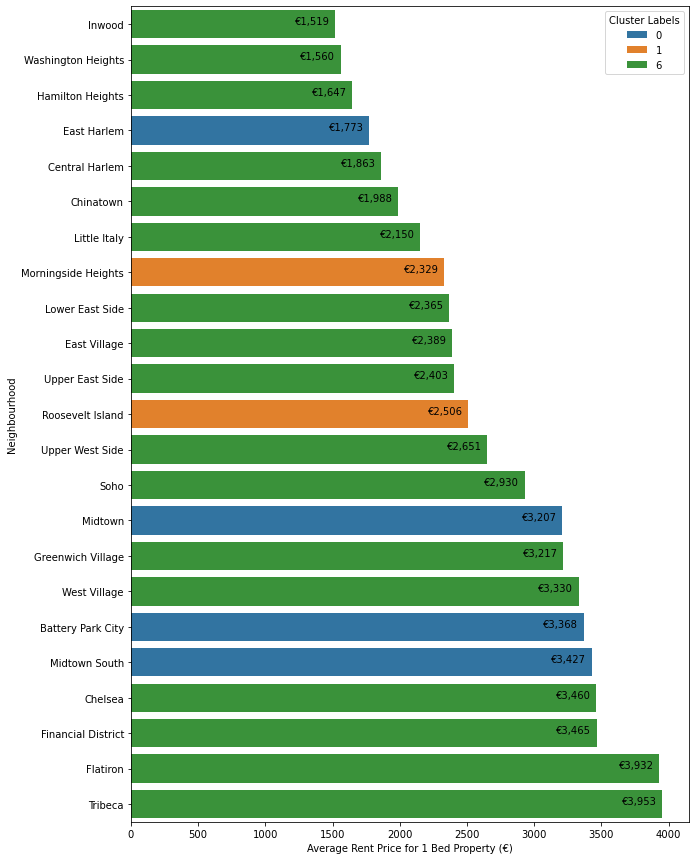

In [36]:
#Plot of the rent prices per neighbourhoods
NY.sort_values(by=['2018-Q3 Rent (€)'], inplace=True)
plt.figure(figsize=(10, 15))
ax = sns.barplot(x="2018-Q3 Rent (€)", y="Neighbourhood", hue="Cluster Labels", data=NY, dodge=False)
ax.set_xlabel("Average Rent Price for 1 Bed Property (€)")

for index, value in enumerate(NY['2018-Q3 Rent (€)']):
    label = str('€') + format(int(value), ',') #format int with commas
     # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value-300, index), color='black')

Can see from the above plot that the rent in Manhattan has a wide range of rent prices for 1bd properties, with the minimum being €1519 in Inwood and the maximum being €3953 in Tribeca. It seems generally neighbourhoods in Cluster 0 have higher rents than those in Cluster 1, although this is not a hard and fast rule. Cluster 6 has a wide range of rent values. Next a similar analysis will be performed on Dublin neighbourhoods and finally the rents of similar neighbourhoods in each city will be compared.

In [37]:
#Read in Dublin 
dub_rent = pd.read_csv('Data/dublin_rents_2018.csv')
#Rename columns
dub_rent.rename(columns={'Dublin':'Borough', '1178.09':'2018 Q1', '1206.18':'2018 Q2', '1229.53':'2018 Q3', '1234.56':'Q4'}, inplace=True)
#Filter to keep only the columns of interest
dub_rent = dub_rent[['Borough','2018 Q3']]
#Split the neighbourhood string to keep just the neighbourhood name in the format we want
dub_rent['Borough']=dub_rent['Borough'].str.split(',').str[0]

In [38]:
#Some neighbourhood names are there own row in the rents dataset
#However in the Dublin neighbourhood dataset these neighbourhoods all fall under the same Borough
#So I will need to find the average rent of these neighbourhoods and combine them into a single row
dub_rent['Borough']['Swords'] = dub_rent['2018 Q3'][[2,4,7]].mean()
dub_rent['Borough']['Dun Laoghaire'] = dub_rent['2018 Q3'][[3,5,6]].mean()
dub_rent.drop(index=[2,4,5,6], inplace=True)
dub_rent.rename(columns={'2018 Q3':'2018-Q3 Rent (€)' }, inplace=True)
dub_rent.reset_index(drop=True, inplace=True)
dub_rent['Borough'][2]== 'Dun Laoghaire/Rathdown'
dub_rent['Borough'][22] == 'Leopardstown'
dub_rent

/Users/warren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/warren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Borough,2018-Q3 Rent (€)
0,Balbriggan,904.92
1,Blackrock,1348.95
2,Dun Laoghaire,1296.66
3,Swords,1133.32
4,Dublin 1,1197.12
5,Dublin 2,1428.03
6,Dublin 3,1117.31
7,Dublin 4,1412.12
8,Dublin 5,1066.51
9,Dublin 6,1100.05


In [39]:
DUB = DUB.merge(dub_rent, on='Borough', how='inner')
DUB

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,2018-Q3 Rent (€)
0,D01,Dublin 1,North Inner City,53.34814,-6.25740,3,Pub,Coffee Shop,Café,Burger Joint,Italian Restaurant,Bookstore,Hotel,Sushi Restaurant,Clothing Store,Theater,1197.12
1,D02,Dublin 2,South Inner City,53.34475,-6.25925,3,Pub,Coffee Shop,Café,Restaurant,Italian Restaurant,Burger Joint,Cocktail Bar,Bookstore,Theater,Burrito Place,1428.03
2,D03,Dublin 3,"Clontarf, East Wall, Marino, Fairview",53.35855,-6.24124,3,Italian Restaurant,Café,Pub,Supermarket,Bar,Stadium,Convenience Store,Coffee Shop,Fast Food Restaurant,Gastropub,1117.31
3,D04,Dublin 4,"Ballsbridge, Donnybrook, Ringsend",53.33780,-6.23353,3,Pub,Café,Hotel,Coffee Shop,Bar,Restaurant,Gym / Fitness Center,Plaza,Indian Restaurant,Farmers Market,1412.12
4,D05,Dublin 5,"Artane, Coolock, Kilbarrack, Raheny",53.38272,-6.20627,5,Grocery Store,Supermarket,Convenience Store,Pub,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Pizza Place,Bus Stop,Pharmacy,1066.51
5,D06,Dublin 6,"Ranelagh, Rathmines, Rathgar",53.33157,-6.25448,3,Café,Restaurant,Pub,Coffee Shop,Hotel,Park,Hotel Bar,Cocktail Bar,French Restaurant,Indian Restaurant,1100.05
6,D07,Dublin 7,"Arbour Hill, Cabrea, Smithfield, Phibsboro, St...",53.35293,-6.28467,3,Pub,Bar,Café,Coffee Shop,Supermarket,Hotel,Bistro,Tram Station,Fish & Chips Shop,Breakfast Spot,1002.54
7,D08,Dublin 8,"Inchicore, Islandbridge, Kilmainham, Portobell...",53.33709,-6.28656,3,Café,Pub,Grocery Store,Coffee Shop,Restaurant,Brewery,Chinese Restaurant,Bar,Tram Station,Convenience Store,1192.18
8,D09,Dublin 9,"Drumcondra, Santry, Whitehall, Beaumont",53.38309,-6.24616,3,Pub,Fast Food Restaurant,Clothing Store,Betting Shop,Restaurant,Coffee Shop,Bus Stop,Burger Joint,Supermarket,Chinese Restaurant,1062.71
9,D10,Dublin 10,Ballyfermot,53.34240,-6.35576,4,Hotel,Chinese Restaurant,Café,Go Kart Track,Grocery Store,Dive Bar,Donut Shop,Electronics Store,Discount Store,Falafel Restaurant,1044.91


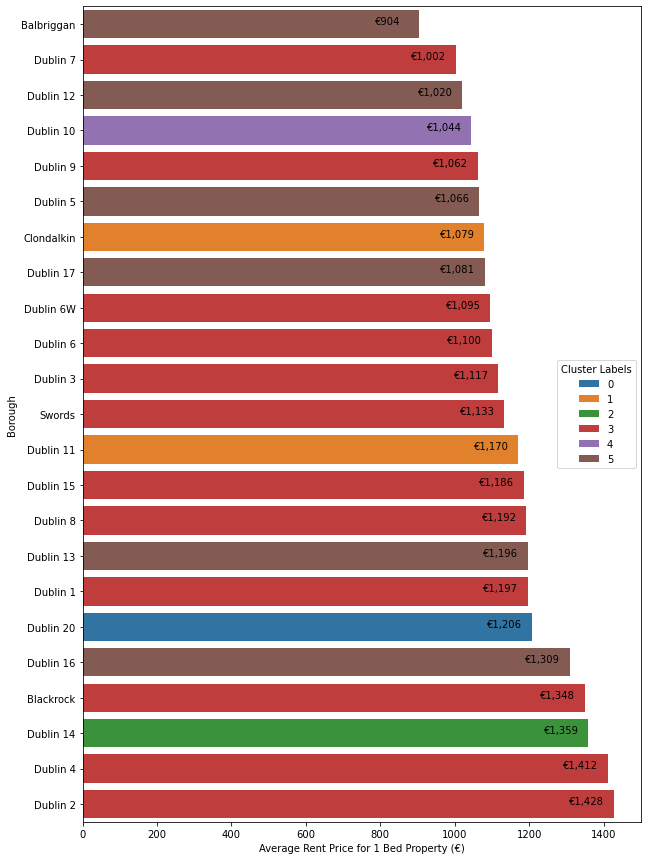

In [40]:
#Plot of the rent prices per neighbourhoods
DUB.sort_values(by=['2018-Q3 Rent (€)'], inplace=True)
plt.figure(figsize=(10, 15))
ax = sns.barplot(x='2018-Q3 Rent (€)', y="Borough", hue="Cluster Labels", data=DUB, dodge=False)
ax.set_xlabel("Average Rent Price for 1 Bed Property (€)")

for index, value in enumerate(DUB['2018-Q3 Rent (€)']):
    label = str('€') + format(int(value), ',') #format int with commas
     # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value-120, index), color='black')

Can see that Dublin has lower rents across the board compared to those in New York, with the highest rent being less than the lowest rent in New York.

In [41]:
NY_DUB = pd.concat([NY,DUB])
NY_DUB = NY_DUB[NY_DUB['Cluster Labels'].isin([0,1])]

In [43]:
NY_DUB

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,2018-Q3,2018-Q3 Rent (€),Postal Code
5,Manhattan,East Harlem,40.792249,-73.944182,0,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,French Restaurant,Gym,Grocery Store,Taco Place,2062.666667,1773.893333,NaN
18,Manhattan,Morningside Heights,40.808000,-73.963896,1,Park,Bookstore,American Restaurant,Coffee Shop,Café,Deli / Bodega,Burger Joint,Ice Cream Shop,Grocery Store,Tennis Court,2708.333333,2329.166667,NaN
7,Manhattan,Roosevelt Island,40.762160,-73.949168,1,Deli / Bodega,Plaza,Coffee Shop,Sandwich Place,Gym / Fitness Center,Gym,Dry Cleaner,Greek Restaurant,School,Outdoors & Recreation,2914.000000,2506.040000,NaN
9,Manhattan,Midtown,40.754691,-73.981669,0,Hotel,Bakery,Clothing Store,Coffee Shop,Theater,Steakhouse,Bookstore,Café,Sporting Goods Shop,Sushi Restaurant,3730.000000,3207.800000,NaN
19,Manhattan,Battery Park City,40.711932,-74.016869,0,Park,Hotel,Coffee Shop,Gym,Memorial Site,Shopping Mall,Food Court,Clothing Store,Gourmet Shop,Boat or Ferry,3916.666667,3368.333333,NaN
21,Manhattan,Midtown South,40.748510,-73.988713,0,Korean Restaurant,Hotel,Japanese Restaurant,Cosmetics Shop,Dessert Shop,American Restaurant,Burger Joint,Gym / Fitness Center,Coffee Shop,Yoga Studio,3986.000000,3427.960000,NaN
18,Clondalkin,Clondalkin,53.321700,-6.406260,1,Convenience Store,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Supermarket,Canal Lock,Playground,Bar,Athletics & Sports,Restaurant,NaN,1079.960000,D22
10,Dublin 11,"Ballymun, Finglas, Glasnevin",53.388880,-6.298660,1,Grocery Store,Fast Food Restaurant,Hotel,Liquor Store,Hobby Shop,Department Store,Coffee Shop,Electronics Store,Pizza Place,Pet Store,NaN,1170.580000,D11
17,Dublin 20,"Chapelizod, Palmerstown",53.351430,-6.378080,0,Supermarket,Clothing Store,Coffee Shop,Sandwich Place,Fast Food Restaurant,Burger Joint,Gym,Portuguese Restaurant,Furniture / Home Store,Park,NaN,1206.670000,D20


In [44]:
NY_DUB['Neighbourhood'][18]== NY_DUB['Borough'][18]
NY_DUB['Neighbourhood'][10] == NY_DUB['Borough'][10]
NY_DUB['Neighbourhood'][17] == NY_DUB['Borough'][17]
NY_DUB = NY_DUB[['Neighbourhood','Cluster Labels','2018-Q3 Rent (€)']]

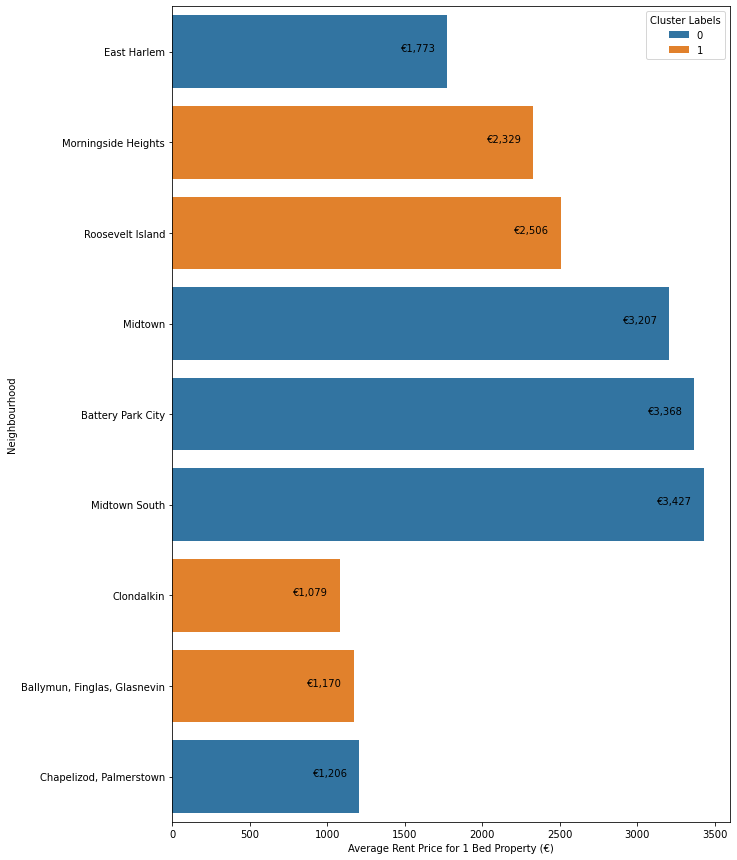

In [45]:
plt.figure(figsize=(10, 15))
ax = sns.barplot(x='2018-Q3 Rent (€)', y="Neighbourhood", hue="Cluster Labels", data=NY_DUB, dodge=False)
ax.set_xlabel("Average Rent Price for 1 Bed Property (€)")

for index, value in enumerate(NY_DUB['2018-Q3 Rent (€)']):
    label = str('€') + format(int(value), ',') #format int with commas
     # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value-300, index), color='black')

The above plot is a like for like comparison of the Dublin and Manhattan neighbourhoods that have the most similar venues. It shows that the neighbourhoods in Dublin have significantly lower rent than those in Manhattan, with Manhattan rents being 70-230% higher than those in similar neighbourhoods in Dublin. The major caveats to this analysis is that the similarities between neighbourhoods is defined only by the type of venues in each area and does not account for any demographic, infrastructure or economic information about each neighbourhood. Additionally, the rent information does not correct for the different median salaries and cost of living in each city.  